## Data Prep

In [1]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [2]:
df.head

<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099192   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094017   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087117   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089273   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091861   
...                ...         ...         ...         ...         ...   
2024-04-18  168.029999  168.639999  166.550003  167.039993  167.039993   
2024-04-19  166.210007  166.399994  164.080002  165.000000  165.000000   
2024-04-22  165.520004  167.259995  164.770004  165.839996  165.839996   
2024-04-23  165.350006  167.050003  164.919998  166.899994  166.899994   
2024-04-24  166.399994  169.300003  166.210007  169.020004  169.020004   

       

In [3]:
reversed_df = df.iloc[::-1]

In [4]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [5]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(df))

# Split data into forward and backward sets
X_fwd = df.values
y_fwd = df.iloc[:, 4].values  # Assuming the target is at index 4

X_bkwd = reversed_df.values
y_bkwd = reversed_df.iloc[:, 4].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler_fwd = StandardScaler()
X_train_fwd_scaled = scaler_fwd.fit_transform(X_train_fwd)
X_test_fwd_scaled = scaler_fwd.transform(X_test_fwd)

scaler_bkwd = StandardScaler()
X_train_bkwd_scaled = scaler_bkwd.fit_transform(X_train_bkwd)
X_test_bkwd_scaled = scaler_bkwd.transform(X_test_bkwd)

In [16]:
# Create sequences for training data
seq_length = 5
prediction_length = 1
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd_scaled, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd_scaled, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd_scaled, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd_scaled, seq_length, prediction_length)

In [ ]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

## Simple RNN

### Model Definition

In [13]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [14]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader, test_loader):
    train_loss_values = []
    test_loss_values = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
        
        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels.unsqueeze(-1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_values.append(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')
        
    return train_loss_values, test_loss_values


### Forward and Backward Training

Running on CPU
Epoch [1/50], Train Loss: 0.2200
Epoch [1/50], Test Loss: 211.6806
Epoch [2/50], Train Loss: 0.0259
Epoch [2/50], Test Loss: 197.1096
Epoch [3/50], Train Loss: 0.0105
Epoch [3/50], Test Loss: 188.1763
Epoch [4/50], Train Loss: 0.0059
Epoch [4/50], Test Loss: 182.6846
Epoch [5/50], Train Loss: 0.0042
Epoch [5/50], Test Loss: 178.8592
Epoch [6/50], Train Loss: 0.0035
Epoch [6/50], Test Loss: 176.2925
Epoch [7/50], Train Loss: 0.0031
Epoch [7/50], Test Loss: 174.3907
Epoch [8/50], Train Loss: 0.0029
Epoch [8/50], Test Loss: 172.9912
Epoch [9/50], Train Loss: 0.0028
Epoch [9/50], Test Loss: 172.0288
Epoch [10/50], Train Loss: 0.0029
Epoch [10/50], Test Loss: 171.1399
Epoch [11/50], Train Loss: 0.0027
Epoch [11/50], Test Loss: 170.4436
Epoch [12/50], Train Loss: 0.0027
Epoch [12/50], Test Loss: 169.9399
Epoch [13/50], Train Loss: 0.0027
Epoch [13/50], Test Loss: 169.5266
Epoch [14/50], Train Loss: 0.0027
Epoch [14/50], Test Loss: 168.9284
Epoch [15/50], Train Loss: 0.0027
Epo

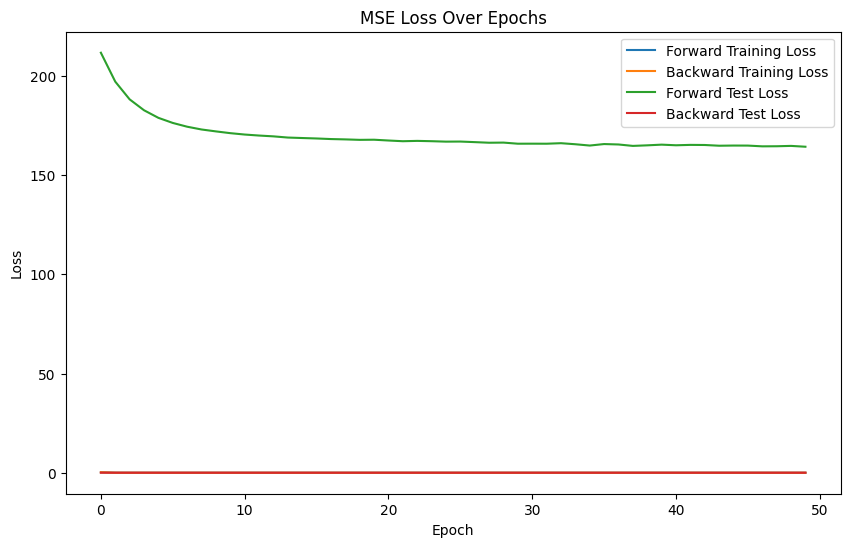

In [18]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 50

# Forward Model Initialization and Training 
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## Transformer

### Model Definition

In [19]:
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size)  # Assuming input is already a feature vector
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  # Output is a single value
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  # Ensure input is properly sized
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [20]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2
num_epochs = 50

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/christopherguarino/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss for this epoch
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_test_loss += val_loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)  # Store test loss for this epoch

        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses  # Return the loss lists for plotting


In [22]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

### Forward and Backward Training

Epoch [1/50]: Train Loss: 0.5032, Test Loss: 239.1007
Epoch [2/50]: Train Loss: 0.1910, Test Loss: 224.4180
Epoch [3/50]: Train Loss: 0.1436, Test Loss: 216.9664
Epoch [4/50]: Train Loss: 0.1196, Test Loss: 212.7408
Epoch [5/50]: Train Loss: 0.1015, Test Loss: 207.9486
Epoch [6/50]: Train Loss: 0.0844, Test Loss: 205.7106
Epoch [7/50]: Train Loss: 0.0760, Test Loss: 203.3932
Epoch [8/50]: Train Loss: 0.0728, Test Loss: 201.0070
Epoch [9/50]: Train Loss: 0.0628, Test Loss: 197.3926
Epoch [10/50]: Train Loss: 0.0561, Test Loss: 195.9556
Epoch [11/50]: Train Loss: 0.0551, Test Loss: 195.4455
Epoch [12/50]: Train Loss: 0.0572, Test Loss: 195.1607
Epoch [13/50]: Train Loss: 0.0529, Test Loss: 194.5917
Epoch [14/50]: Train Loss: 0.0496, Test Loss: 192.2449
Epoch [15/50]: Train Loss: 0.0496, Test Loss: 192.9783
Epoch [16/50]: Train Loss: 0.0462, Test Loss: 191.8100
Epoch [17/50]: Train Loss: 0.0460, Test Loss: 190.9764
Epoch [18/50]: Train Loss: 0.0461, Test Loss: 190.1786
Epoch [19/50]: Trai

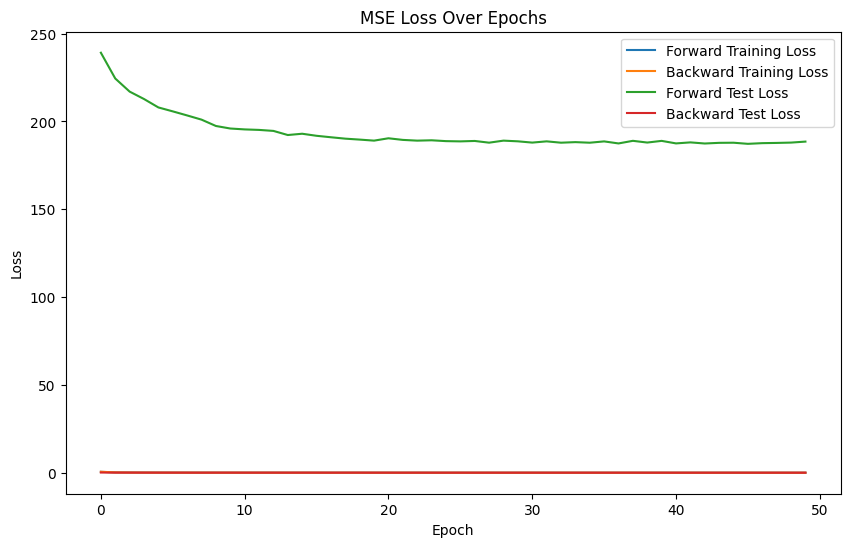

In [23]:
import matplotlib.pyplot as plt

# Assuming train_model has been called and returned loss values for both forward and backward training
model.apply(reset_weights)  # Reset model weights
loss_values_fwd_train, loss_values_fwd_test = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs)
model.apply(reset_weights)  # Reset model weights
loss_values_bkwd_train, loss_values_bkwd_test = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()


You know what I am struggling with. Becasue this time series data is heavily influenced by macro economics, so when you split the data the is a chance that oyu are splitting it around a pivotal moment in the stock's life. So how do you knwo if the testing evaluation is representative of the overall trends. This could explain why the data running backward is testing well where as the loss on the forward running data is very high. 